<a href="https://colab.research.google.com/github/xyvlin/machine_learning_hw/blob/main/bikeDemand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
data = pd.read_csv('/content/bikeData.csv')
print(data.shape)
data.head()

(10886, 10)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [ ]:
# 70% training
# 15% validation
# 15% testing

# data --> training + temp
train, temp = train_test_split(data, test_size=0.3, random_state=42)

# temp --> validation + testing
validation, test = train_test_split(temp, test_size=0.5, random_state=42)

### preprocessing

#### count skewed

(1.0, 970.0)

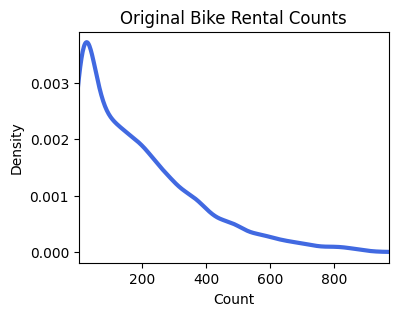

In [ ]:
plt.figure(figsize=(4, 3))
train['count'].plot(kind='kde', color='royalblue', linewidth=3)
plt.title('Original Bike Rental Counts')
plt.xlabel('Count')
plt.ylabel('Density')
plt.xlim(train['count'].min(), train['count'].max())

(0.6931471805599453, 6.878326468291325)

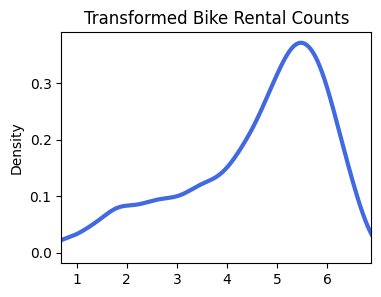

In [ ]:
train['log_count'] = train['count'].apply(np.log1p)
plt.figure(figsize=(4, 3))
train['log_count'].plot(kind='kde', color='royalblue', linewidth=3)
plt.title('Transformed Bike Rental Counts')
plt.xlabel('Count')
plt.ylabel('Density')
plt.xlim(train['log_count'].min(), train['log_count'].max())

#### split datetime

In [ ]:
def time_process(df):
    df['month'] = pd.DatetimeIndex(df['datetime']).month
    df['day'] = pd.DatetimeIndex(df['datetime']).day
    df['hour'] = pd.DatetimeIndex(df['datetime']).hour
    df['weekday'] = pd.DatetimeIndex(df['datetime']).dayofweek
    return df
train = time_process(train)
validation = time_process(validation)
test = time_process(test)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,log_count,month,day,hour,weekday
613,2011-02-08 17:00:00,1,0,1,1,9.02,9.090,32,39.0007,176,5.176150,2,8,17,1
4030,2011-09-18 23:00:00,3,0,0,1,22.14,25.760,68,12.9980,54,4.007333,9,18,23,6
3582,2011-08-19 04:00:00,3,0,1,1,26.24,28.790,83,0.0000,8,2.197225,8,19,4,4
10101,2012-11-06 06:00:00,4,0,1,1,9.02,11.365,69,8.9981,149,5.010635,11,6,6,1
1430,2011-04-05 11:00:00,2,0,1,3,13.12,14.395,81,30.0026,19,2.995732,4,5,11,1


#### check missing values

In [ ]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64


#### choose features

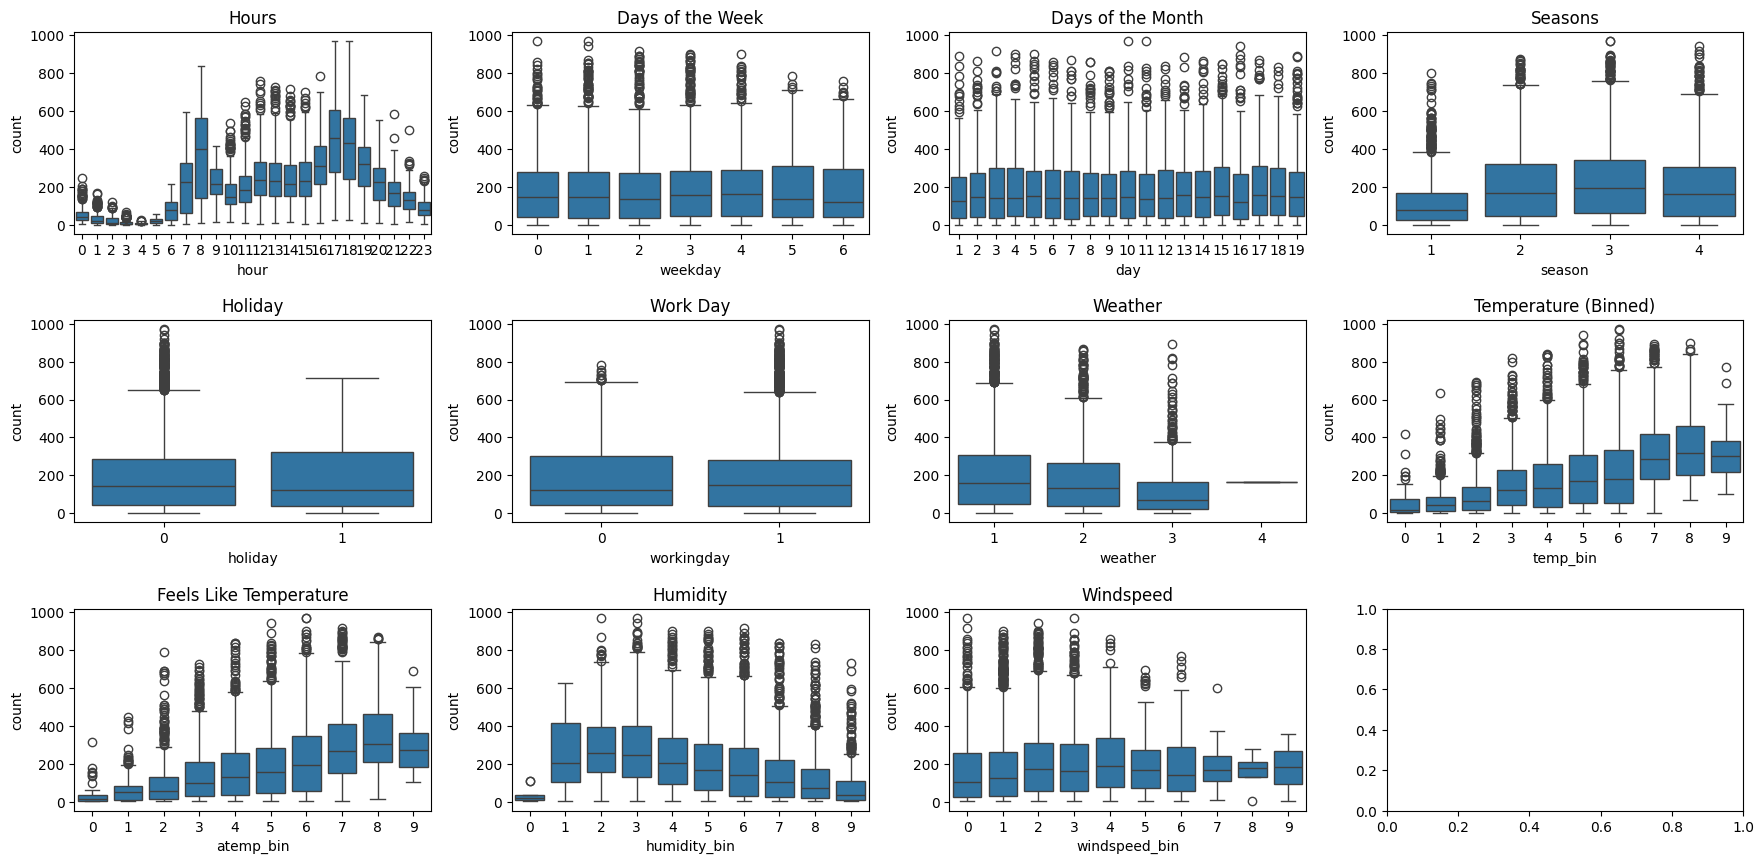

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(18, 9))

sns.boxplot(x='hour',y='count',data=train,ax=axes[0,0])
axes[0,0].set_title('Hours')

sns.boxplot(x='weekday',y='count',data=train,ax=axes[0,1])
axes[0,1].set_title('Days of the Week')

sns.boxplot(x='day',y='count',data=train,ax=axes[0,2])
axes[0,2].set_title('Days of the Month')

sns.boxplot(x='season',y='count',data=train,ax=axes[0,3])
axes[0,3].set_title('Seasons')

sns.boxplot(x='holiday',y='count',data=train,ax=axes[1,0])
axes[1,0].set_title('Holiday')

sns.boxplot(x='workingday',y='count',data=train,ax=axes[1,1])
axes[1,1].set_title('Work Day')

sns.boxplot(x='weather',y='count',data=train,ax=axes[1,2])
axes[1,2].set_title('Weather')

train['temp_bin'] = pd.cut(train['temp'], bins=10, labels=False)
sns.boxplot(x='temp_bin', y='count', data=train, ax=axes[1, 3])
axes[1, 3].set_title('Temperature (Binned)')

train['atemp_bin'] = pd.cut(train['atemp'], bins=10, labels=False)
sns.boxplot(x='atemp_bin',y='count',data=train,ax=axes[2,0])
axes[2,0].set_title('Feels Like Temperature')

train['humidity_bin'] = pd.cut(train['humidity'], bins=10, labels=False)
sns.boxplot(x='humidity_bin',y='count',data=train,ax=axes[2,1])
axes[2,1].set_title('Humidity')

train['windspeed_bin'] = pd.cut(train['windspeed'], bins=10, labels=False)
sns.boxplot(x='windspeed_bin',y='count',data=train,ax=axes[2,2])
axes[2,2].set_title('Windspeed')

fig.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.5)
plt.show()

In [ ]:
feature_columns = ['hour','weekday','season','holiday','workingday','weather','temp','humidity','windspeed']

#### seperate X y

In [ ]:
X_train = train[feature_columns]
X_validation = validation[feature_columns]
X_test = test[feature_columns]

In [ ]:
y_train = train['count'].apply(np.log1p)
y_validation = validation['count'].apply(np.log1p)
y_test = test['count'].apply(np.log1p)

### Models

In [ ]:
def rmsle(y_real, y_pre):
  log1 = np.log(y_real+1)
  log2 = np.log(y_pre+1)
  calc = (log1 - log2) ** 2
  return np.sqrt(np.mean(calc))

#### choose model

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_validation)
print(rmsle(y_validation,pred_lr))

0.2299055292616283


In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_validation)
print(rmsle(y_validation,pred_dt))

0.13232034964216952


In [ ]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)
pred_ada = ada.predict(X_validation)
print(rmsle(y_validation,pred_ada))

0.14691167208485512


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_validation)
print(rmsle(y_validation,pred_rf))

0.09378704550690542


### Tuning

#### Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Parameters:", grid_rf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


#### AdaBoost

In [ ]:
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [1, 3, 5]
}

grid_ada = GridSearchCV(
    estimator=AdaBoostRegressor(DecisionTreeRegressor(),random_state=42),
    param_grid=param_grid_ada,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_ada.fit(X_train, y_train)

best_ada = grid_ada.best_estimator_
print("Best Parameters:", grid_ada.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'estimator__max_depth': 5, 'learning_rate': 1, 'n_estimators': 200}


#### Decision Tree

In [ ]:
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print("Best Parameters:", grid_dt.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


#### Tuning Results

In [ ]:
pred_rf_val = best_rf.predict(X_validation)
print("RMSLE (Validation):", rmsle(y_validation, pred_rf_val))

pred_ada_val = best_ada.predict(X_validation)
print("RMSLE (Validation):", rmsle(y_validation, pred_ada_val))

pred_dt_val = best_dt.predict(X_validation)
print("RMSLE (Validation):", rmsle(y_validation, pred_dt_val))

RMSLE (Validation): 0.09383703960065427
RMSLE (Validation): 0.1073051399320616
RMSLE (Validation): 0.10772391984409434


In [ ]:
print("final test score using Random Forest:", rmsle(y_test, best_rf.predict(X_test)))

final test score using Random Forest: 0.0974397593459089


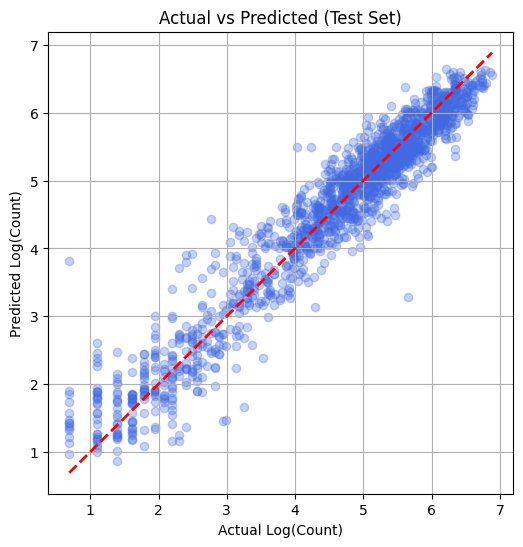

In [ ]:
pred_test = best_rf.predict(X_test)
actual_test = y_test

plt.figure(figsize=(6, 6))
plt.scatter(actual_test, pred_test, alpha=0.3, color='royalblue')
plt.plot([actual_test.min(), actual_test.max()],
         [actual_test.min(), actual_test.max()],
         'r--', linewidth=2)
plt.xlabel('Actual Log(Count)')
plt.ylabel('Predicted Log(Count)')
plt.title('Actual vs Predicted (Test Set)')
plt.grid(True)
plt.show()

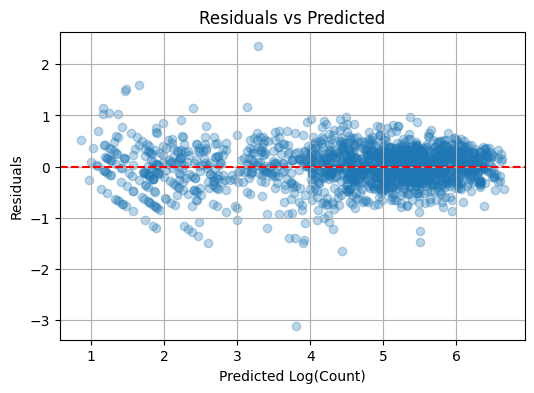

In [ ]:
residuals = actual_test - pred_test

plt.figure(figsize=(6, 4))
plt.scatter(pred_test, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log(Count)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

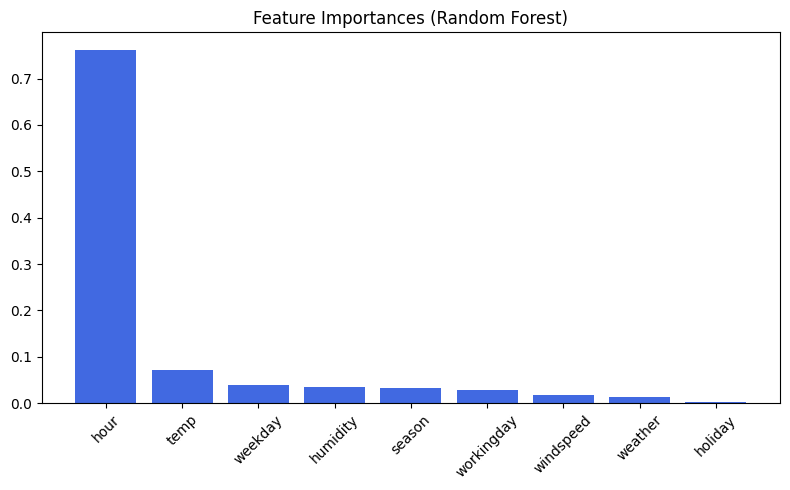

In [ ]:
importances = best_rf.feature_importances_
features = X_train.columns

# Sort and plot
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[sorted_idx], color='royalblue')
plt.xticks(range(len(importances)), features[sorted_idx], rotation=45)
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()
